In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_style("ticks")

import scipy.integrate as integrate
from scipy.optimize import curve_fit

from multiprocessing import Pool

In [2]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus-Gaia-Crossmatch-probgal&isoarea.csv", 
                    usecols=["RA_2", "DEC_2", "zml", "r_petro", "g_petro"])

In [3]:
ra = table["RA_2"]
dec = table["DEC_2"]
zml = table["zml"]
rpetro = table["r_petro"]
gpetro = table["g_petro"]

#### Criteria to select galaxies

In [4]:
mlim = 18
ra_max = 180
ra_min = 150
dec_min = -48
dec_max = -15

mask = (rpetro < mlim) & (zml > 0.005) & (zml < 0.03) & (ra < ra_max) & (ra 
                    > ra_min) & (dec > dec_min) & (dec < dec_max)

ra = np.array(ra[mask])
dec = np.array(dec[mask])
zml = np.array(zml[mask])
rpetro = np.array(rpetro[mask])
gpetro = np.array(gpetro[mask])

#### Define parameters for Hydra Cluster

In [25]:
#Let's do it for Hydra
z_c = 0.01
sigma_c = 0.050 #Just a fake value for now -- need to check what value to use later

#Defining the center of Hydra (in degress)
ra_0 = 159.17
dec_0 = -27.524

#Defining the radius of 1R200 around the center (in degrees)
#R200 = 1.4Mpc + scale of 0.247 Kpc/" ==> radius = 1.5744º
radius = 1.5744

#### Define magnitude and redshift ranges

In [26]:
#We have to check what is the better range of redshifts and magnitudes to use (?)
m = np.arange(8, 21, 0.1)
z = np.linspace(0, 3, len(m))

delta_z = 0.01

### First: define the galaxy photo-z PDF

$$
P_g(z) \propto \frac{1}{\sigma_0 (1+z)} \exp \left( -\frac{(z - z_{p, g})^2}{2 \sigma_0^2 (1+z)^2} \right)
$$
where $\sigma_0$ is the uncertainty in the photo-z estimate (I am thinking of using the $\sigma_{NMAD}$) and $z_{p, g}$ is galaxy's photo-z.

The proportionality has to be such that

$$
\int P_g(z) dz = 1.0
$$

#### Define the redshift uncertainty $\sigma_0$ of the galaxy's photo-z

Here we are going to use $\sigma_0 = \sigma_{NMAD}$ in the same way as defined for CHANCES target selection

[ 1.76886212e-04 -8.07438409e-03  1.23970821e-01 -6.33901493e-01]


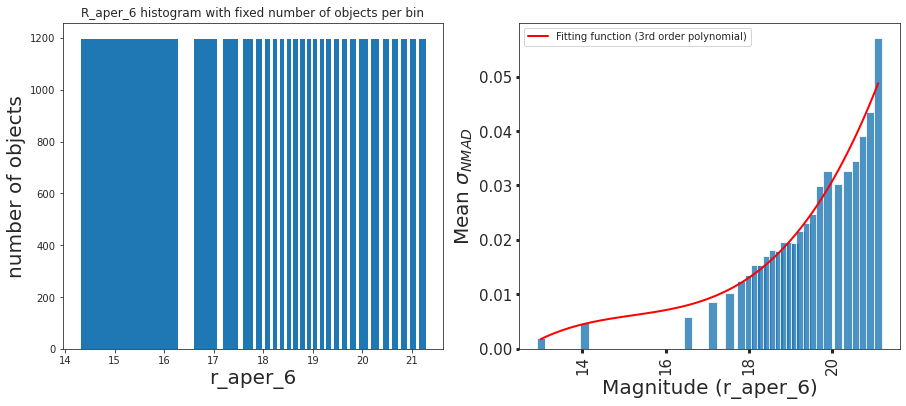

In [8]:
#Estimate sigma_nmad
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))


training_set = pd.read_csv("../CHANCES-target-selection/Results_DF.csv", usecols=['r_aper_6', 'zml', 'z'])

rmag_train = training_set["r_aper_6"]
zml_train = training_set["zml"]
z_train = training_set["z"]


fontsize=20
labelsize=15
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)

n, bins, patches = ax1.hist(rmag_train, histedges_equalN(rmag_train, 25), histtype='bar', rwidth=0.8)
ax1.set_xlabel("r_aper_6", fontsize=fontsize)
ax1.set_ylabel("number of objects", fontsize=fontsize)
ax1.set_title("R_aper_6 histogram with fixed number of objects per bin", fontsize=fontsize*0.6)


mag = np.array(bins)
sigma_nmad = []
mag_bins = []

for i in range(1, len(mag), 1):
    mask_i = (rmag_train > mag[i-1]) & (rmag_train < mag[i])
    delta_z_i = zml_train[mask_i] - z_train[mask_i]
    sigma_nmad.append(np.abs(1.48 * np.median(abs(delta_z_i - np.median(delta_z_i)) / (1 + z_train[mask_i]))))
    mag_bins.append("{:.3f} <= r_mag <= {:.3f}".format(mag[i-1], mag[i]))

    
def func1(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

sigma_nmad_new = np.concatenate((np.array([2e-3]), sigma_nmad))
mag_new = np.concatenate((np.array([13.00]), mag))

xdata = mag_new[:-1]
ydata = sigma_nmad_new

popt1, pcov1 = curve_fit(func1, xdata, ydata)
print(popt1)

ax2 = fig.add_subplot(122)

xnew = np.linspace(xdata[0], xdata[-1], 100)
# ax.scatter(xdata, ydata)
ax2.bar(mag_new[:-1], sigma_nmad_new, alpha=0.8, width=0.2)
ax2.plot(xnew, func1(xnew, *popt1), linewidth=2.0, color='red', label="Fitting function (3rd order polynomial)")
ax2.set_xlabel("Magnitude (r_aper_6)", fontsize=fontsize)
ax2.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, rotation=90)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3)
ax2.legend()
    

def sigma_nmad(r):
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
    return sigma_nmad

In [18]:
x_cluster_r = np.loadtxt("cluster-mock-R/xa.txt")
y_cluster_r = np.loadtxt("cluster-mock-R/ya.txt")
z_cluster_r = np.loadtxt("cluster-mock-R/za.txt")
mag_cluster_r = np.loadtxt("cluster-mock-R/mag_cluster.txt")

xcampo_r = np.loadtxt("cluster-mock-R/xcampo.txt")
ycampo_r = np.loadtxt("cluster-mock-R/ycampo.txt")
zcampo_r = np.loadtxt("cluster-mock-R/zcampo.txt")
mag_campo_r = np.loadtxt("cluster-mock-R/mag_campo.txt")

ra = np.concatenate((xcampo_r, x_cluster_r))
dec = np.concatenate((ycampo_r, y_cluster_r))
zml = np.concatenate((zcampo_r, z_cluster_r))
rpetro = np.concatenate((mag_campo_r, mag_cluster_r))

In [27]:
#Defining an object to take as example
obj = 99

z_pg = zml[obj]
mg = rpetro[obj]

print(z_pg)
print(mg)

#sigma_nmad is a function of magnitude. Here we are going to use rmag magnitude
sigma_0 = sigma_nmad(mg) 

0.0588316028329393
19.1342562723679


In [48]:
#The PDF of the galaxy will then be A * Pg_z(z, z_pg, sigma_0), where z_pg and sigma_0 are the photo-z and its uncertainty for that galaxy

def Pg_z(z, z_pg, sigma_0):
    return (1/(sigma_0 * (1+z))) * np.exp(-(z - z_pg)**2 / (2 * sigma_0**2 * (1+z)**2))

#Carreful! A has to be calculated for each galaxy separetely. Here it is just an example.
A = 1.0 / np.sum(Pg_z(z, z_pg, sigma_0))

In [56]:
print(A)
print(B)

0.009275136836327691
0.01344521533964577


### Second: define the cluster PDF

$$
P_c(z) \propto \frac{1}{\sigma_c (1+z)} \exp \left( -\frac{(z - z_c)^2}{2 \sigma_c^2 (1+z)^2} \right)
$$
where $\sigma_c$ is the uncertainty in the cluster's redshift - when we have the spctroscopic redshift available I think this can be considered almost zero - and $z_c$ is clusters's redshift. 

The proportionality has to be such that

$$
\int P_c(z) dz = 1.0
$$

In [30]:
def Pc_z(z, z_c, sigma_c):
    return (1/(sigma_c * (1+z))) * np.exp(-(z - z_c)**2 / (2 * sigma_c**2 * (1+z)**2))

B = 1.0 / np.sum(Pc_z(z, z_c, sigma_c))

#The PDF of the cluster will then be B * Pg_z(z, z_c, sigma_c), where z_c and sigma_c are the redshift and its uncertainty for the cluster

array([1.96039735e+01, 1.89003172e+01, 1.49816031e+01, 1.00142525e+01,
       5.77118852e+00, 2.92357163e+00, 1.32416300e+00, 5.44284813e-01,
       2.05714146e-01, 7.23220355e-02, 2.38927952e-02, 7.48436445e-03,
       2.24068715e-03, 6.45643920e-04, 1.80171647e-04, 4.89607502e-05,
       1.30194243e-05, 3.40244003e-06, 8.77210598e-07, 2.23873583e-07,
       5.67271378e-08, 1.43094425e-08, 3.60181178e-09, 9.06548049e-10,
       2.28576981e-10, 5.78299738e-11, 1.47019875e-11, 3.76054685e-12,
       9.68859459e-13, 2.51668534e-13, 6.59668613e-14, 1.74612108e-14,
       4.67040807e-15, 1.26301767e-15, 3.45498526e-16, 9.56406657e-17,
       2.68008545e-17, 7.60483556e-18, 2.18559466e-18, 6.36314436e-19,
       1.87699190e-19, 5.61037374e-20, 1.69940199e-20, 5.21673666e-21,
       1.62297715e-21, 5.11727496e-22, 1.63520097e-22, 5.29535087e-23,
       1.73775139e-23, 5.77858652e-24, 1.94698619e-24, 6.64618871e-25,
       2.29830656e-25, 8.05048184e-26, 2.85603973e-26, 1.02608184e-26,
      

#### Plot PDFs

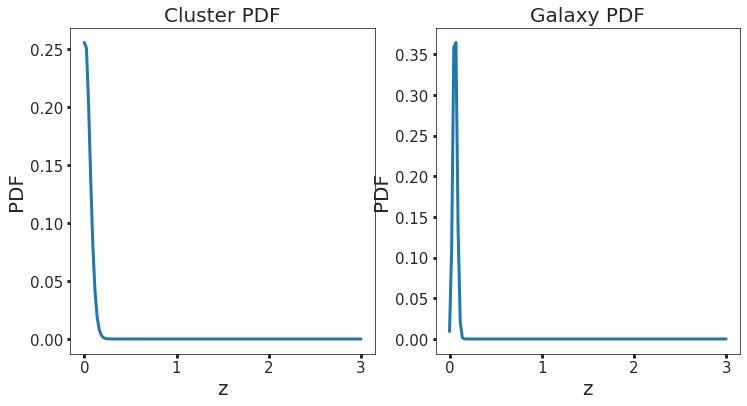

In [22]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(z, B*Pc_z(z, z_c, sigma_c), lw=3.0)
ax1.set_title("Cluster PDF", fontsize=fontsize)
ax2.plot(z, A*Pg_z(z, z_pg, sigma_0), lw=3.0)
ax2.set_title("Galaxy PDF", fontsize=fontsize)

for ax in [ax1, ax2]:
    ax.set_xlabel("z", fontsize=fontsize)
    ax.set_ylabel("PDF", fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=labelsize, width=3)
    ax.yaxis.set_tick_params(labelsize=labelsize, width=3)

### Third: compute the $\beta$ factor:

$$
\beta = \frac{\left< N_{bkg,c}^{loc}(m_g, z_c) \right>}{\left< N_{tot, c}(m_g, z_c, r_{c, g}) \right>}
$$
where $N_{bkg, c}^{loc}$ is the background density defined locally for each cluster, i.e., considering for each halo (or group/cluster) an annulus comprised within 3 and 5 Mpc from the center. Here, I am thinking of considering instead something like 3 - 5 $R_{200}$, which makes more sense considering that each cluster has a different characteristic radius. We then have:

$$
N_{bkg, c}^{loc} = \frac{1}{A} \Sigma_g P_g(z) P_g(m)
$$
where we just consider the pdfs $P_g(z)$ and $P_g(m)$ for the galaxies within the annulus, and A is the area of the annulus. Similarly to $P_g(z)$, $P_g(m)$ is a gaussian: $P_g(m) = \mathcal{N}(m, \mu=m_g, \sigma=\delta m)$, with $\delta m = 0.1$.

We then define the running mean $\left< N_{bkg,c}^{loc} (m, z) \right>$ as

$$
\left< N_{bkg,c}^{loc} (m, z) \right> = \int_{m - 5 \delta m}^{m + 5 \delta m} \int_{z - 2\sigma(z)}^{z + 2\sigma(z)} N_{bkg,c}^{loc} (m', z') dz' dm' ,
$$
where $\sigma(z) = \sigma_0 (1+z)$ denotes the $1 \sigma$ statistical redshift uncertainty.

For each halo c we also introduce the local number density $N_{tot, c}(m, z, r)$ which is equal to the galaxy number counts per unit redshift, magnitude, and solid angle at a given projected physical separation within $(r; r+dr)$ from the halo center. In analogy with the background, we similarly define a running mean as follows:

$$
\left< N_{tot,c}(m, z, r) \right> = \int_{m - 5 \delta m}^{m + 5 \delta m} \int_{z - 2\sigma(z)}^{z + 2\sigma(z)} \int_{r_<}^{r_>} N_{tot,c} (m', z', r') dr' dz' dm' ,
$$
where $r_<$ and $r_>$ are the projected separations which define a subtended area, centered at r, equivalent to that of a circle of 450 kpc radius at redshift $z$. In effect, $\left< N_{tot,c}(m, z, r) \right>$ is going to be an integral in $z$ and $m$ for the galaxies within $r_<$ and $r_>$.

In [12]:
def N(z, m, z_pg, sigma_0, mg, delta_m):
    pdf_z = lambda z, z_pg, sigma_0: (1/(sigma_0 * (1+z))) * np.exp(-(z - z_pg)**2 / (2 * sigma_0**2 * (1+z)**2))
    pdf_m = lambda m, mg, delta_m: (1/delta_m) * np.exp(-(m - mg)**2 / (2 * delta_m**2))
    
    A = 1.0 / integrate.quad(pdf_z, 0, 3, args=(z_pg, sigma_0))[0]
    
    B = 1.0 / integrate.quad(pdf_m, 8, 21, args=(mg, delta_m))[0]
    
    #We have to perform a sum of pdf_z * pdf_m for all galaxies within the annulus defined for N_bkg or N_tot in each case
    return A*pdf_z(z, z_pg, sigma_0) * B*pdf_m(m, mg, delta_m)

In [13]:
def N_mean(N, z, m, z_pg, sigma_0, mg, delta_m):
    
    sigma_z = sigma_0 * (1+z)
    result = integrate.dblquad(N, m-5*delta_m, m+5*delta_m, z-2*sigma_z, z+2*sigma_z, args=(z_pg, sigma_0, mg, delta_m))
    return result[0]

In [14]:
delta_m = 0.1

N_mean(N, z_c, mg, z_pg, sigma_0, mg, delta_m)

0.5563868871535885

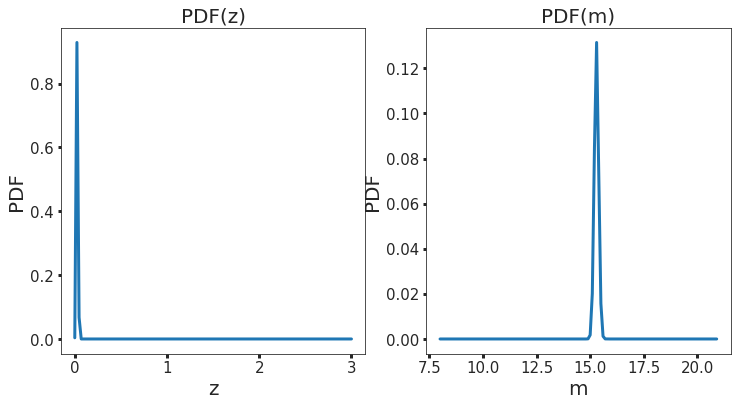

In [15]:
pdf_z = lambda z, z_pg, sigma_0: (1/(sigma_0 * (1+z))) * np.exp(-(z - z_pg)**2 / (2 * sigma_0**2 * (1+z)**2))
pdf_m = lambda m, mg, delta_m: (1/delta_m) * np.exp(-(m - mg)**2 / (2 * delta_m**2))

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(z, A*pdf_z(z, z_pg, sigma_0), lw=3)
ax1.set_title("PDF(z)", fontsize=fontsize)
ax1.set_xlabel("z", fontsize=fontsize)
ax1.set_ylabel("PDF", fontsize=fontsize)

ax2.plot(m, B*pdf_m(m, mg, delta_m), lw=3)
ax2.set_title("PDF(m)", fontsize=fontsize)
ax2.set_xlabel("m", fontsize=fontsize)
ax2.set_ylabel("PDF", fontsize=fontsize)

for ax in [ax1, ax2]:
    ax.xaxis.set_tick_params(labelsize=labelsize, width=3)
    ax.yaxis.set_tick_params(labelsize=labelsize, width=3)

In [16]:
from astropy.cosmology import FlatLambdaCDM

In [17]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
arcsec_per_kpc = cosmo.arcsec_per_kpc_proper(z=z_c).value

In [18]:
def haversine(x1, y1, x2, y2):
    '''
    Calculate the distance between points (x1, y1) and (x2, y2) using haversine metric
    
    Basically, x1 and x2 are the right ascencions, and y1 and y2 are the declinations
    '''
    
    return 2*np.arcsin(np.sqrt(np.sin((x2-x1)/2)**2 + np.cos(x1)*np.cos(x2)*np.sin((y2-y1)/2)**2))

In [19]:
#Distances from all galaxies to the center of the cluster. Results in radians.
dists = haversine(np.deg2rad(ra_0), np.deg2rad(dec_0), np.deg2rad(ra), np.deg2rad(dec))

In [20]:
mask_N_bkg = (np.rad2deg(dists) > (3e3 * arcsec_per_kpc)/3600) & (np.rad2deg(dists) < (5e3 * arcsec_per_kpc)/3600)

#### The idea is to calculate N_mean() for all galaxies inside this annulus, sum the integrals, and divide by the area of the annulus. This will be $<N_{bkg}>$

In [48]:
import time
t0 = time.time()

def calculate_N_bkg_c(mg_i, zml, rpetro, z_c, N, delta_m):
    N_bkg_c_i = 0
    for z_pg_j, mg_j in zip(zml[mask_N_bkg], rpetro[mask_N_bkg]):
        sigma_0 = sigma_nmad(mg_j)
        N_bkg_c_ij = N_mean(N, z_c, mg_i, z_pg_j, sigma_0, mg_j, delta_m)
        N_bkg_c_i += N_bkg_c_ij
    return N_bkg_c_i


def parallelize_code():
    N_bkg_c = []
    pool = Pool(processes=10)  # Initialize the process pool

    # Use the process pool to parallelize the computation
    N_bkg_c = pool.starmap(calculate_N_bkg_c, [(mg_i, zml, rpetro, z_c, N, delta_m) for mg_i in rpetro])

    return N_bkg_c

# Call the parallelized function
N_bkg_c = parallelize_code()


(time.time() - t0)/60

205.67310729026795

(array([ 2.,  0.,  0.,  1.,  0., 12.,  1.,  3.,  2.,  4.,  4., 19., 68.,
        43., 45., 14., 14., 59., 53., 85., 71., 32., 21., 25., 21., 19.,
        26., 58.,  7., 10.,  5.,  8.,  4.,  2., 13.,  6.,  7.,  4., 10.,
         6.,  5.,  8.,  8.,  7., 10.,  5., 10., 25., 37., 32.]),
 array([2.18609706e-04, 3.66567813e-01, 7.32917016e-01, 1.09926622e+00,
        1.46561542e+00, 1.83196462e+00, 2.19831383e+00, 2.56466303e+00,
        2.93101223e+00, 3.29736144e+00, 3.66371064e+00, 4.03005984e+00,
        4.39640905e+00, 4.76275825e+00, 5.12910745e+00, 5.49545665e+00,
        5.86180586e+00, 6.22815506e+00, 6.59450426e+00, 6.96085347e+00,
        7.32720267e+00, 7.69355187e+00, 8.05990107e+00, 8.42625028e+00,
        8.79259948e+00, 9.15894868e+00, 9.52529789e+00, 9.89164709e+00,
        1.02579963e+01, 1.06243455e+01, 1.09906947e+01, 1.13570439e+01,
        1.17233931e+01, 1.20897423e+01, 1.24560915e+01, 1.28224407e+01,
        1.31887899e+01, 1.35551391e+01, 1.39214883e+01, 1.42878375e+

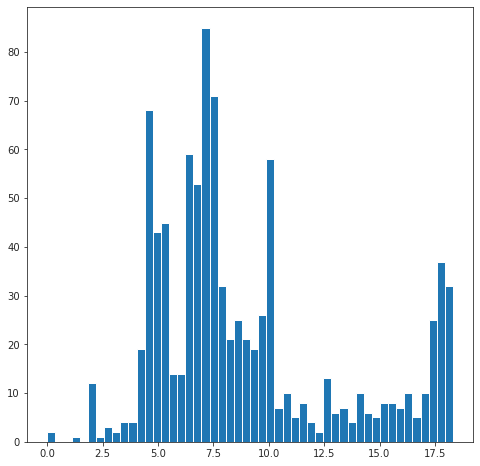

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.hist(N_bkg_c, bins=50)

#### In the case of $\left< N_{tot} \right>$, if I understood well, I will have to compute the separtion $r_{c, g}$ between the galaxy and the center of the cluster, select all galaxies within ($r_{c, g} -\ 450/2\ \text{Kpc}$ and $r_{c, g} +\ 450/2\ \text{Kpc}$), and compute the integral for those galaxies

In [21]:
t0 = time.time()

def calculate_N_tot_c(params):
    mg_i, d, zml, rpetro, z_c, delta_m = params
    N_tot_c_i = 0

    mask_N_tot = (np.rad2deg(dists) > (d - (450/2 * arcsec_per_kpc)/3600)) & (np.rad2deg(dists) < (d + (450/2 * arcsec_per_kpc)/3600))

    for z_pg_j, mg_j in zip(zml[mask_N_tot], rpetro[mask_N_tot]):
        sigma_0 = sigma_nmad(mg_j)
        N_tot_c_ij = N_mean(N, z_c, mg_i, z_pg_j, sigma_0, mg_j, delta_m)
        N_tot_c_i += N_tot_c_ij

    return N_tot_c_i

def parallelize_code():
    N_tot_c = []
    pool = Pool(processes=5)  # Initialize the process pool

    params = [(mg_i, d, zml, rpetro, z_c, delta_m) for mg_i, d in zip(rpetro, np.rad2deg(dists))]

    N_tot_c = pool.map(calculate_N_tot_c, params)

    return N_tot_c

# Call the parallelized function
N_tot_c = parallelize_code()

(time.time() - t0)/60

(array([11., 28., 32., 29., 63., 24., 38., 53., 42., 43., 41., 36., 44.,
        22., 38., 27., 35., 33., 19., 25., 23., 22., 33., 17., 16., 25.,
        15., 17.,  9., 10., 12.,  6.,  8.,  5.,  3.,  4.,  3.,  2.,  2.,
         4.,  2.,  0.,  3.,  1.,  0.,  0.,  1.,  1.,  1.,  3.]),
 array([ 0.44666522,  0.77539732,  1.10412942,  1.43286152,  1.76159361,
         2.09032571,  2.41905781,  2.74778991,  3.076522  ,  3.4052541 ,
         3.7339862 ,  4.0627183 ,  4.3914504 ,  4.72018249,  5.04891459,
         5.37764669,  5.70637879,  6.03511088,  6.36384298,  6.69257508,
         7.02130718,  7.35003928,  7.67877137,  8.00750347,  8.33623557,
         8.66496767,  8.99369976,  9.32243186,  9.65116396,  9.97989606,
        10.30862816, 10.63736025, 10.96609235, 11.29482445, 11.62355655,
        11.95228864, 12.28102074, 12.60975284, 12.93848494, 13.26721704,
        13.59594913, 13.92468123, 14.25341333, 14.58214543, 14.91087752,
        15.23960962, 15.56834172, 15.89707382, 16.22580591,

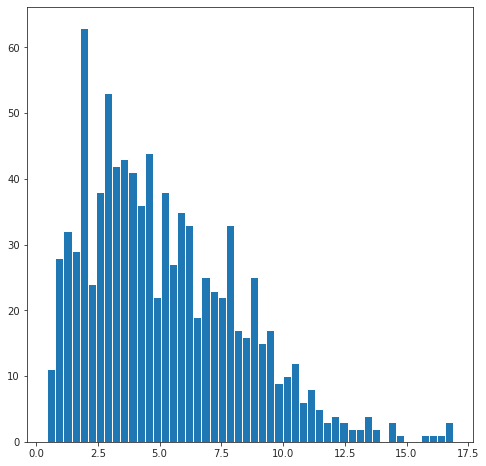

In [25]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.hist(N_tot_c, bins=50)

10.05765432637038


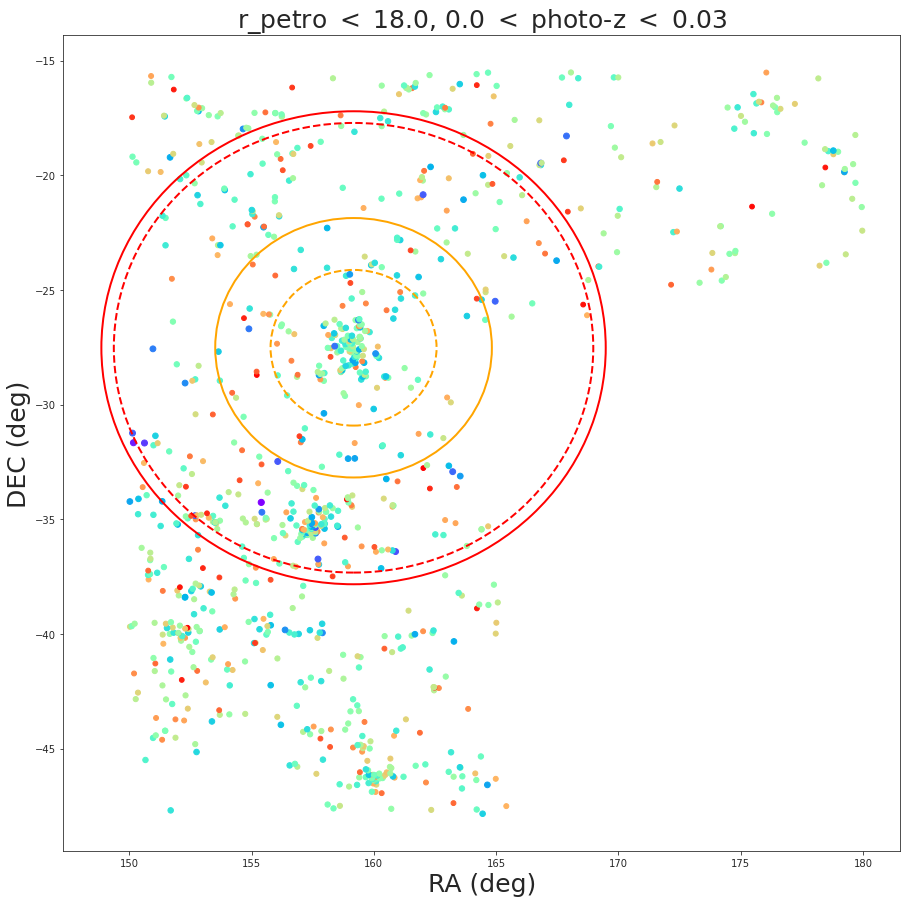

In [24]:
fontsize = 25
labelsize = 20

from mpl_toolkits.axes_grid1 import make_axes_locatable
cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

sc1 = ax.scatter(x=ra, y=dec, c=rpetro, cmap=cm2, s=(1/rpetro)*400)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title(r"r_petro $<$ {:.1f}, 0.0 $<$ photo-z $<$ 0.03".format(mlim), fontsize=fontsize)

#=========================================================
g = 130
circle1_tot = plt.Circle((ra_0, dec_0), (np.asarray(np.rad2deg(dists))[g] - (450/2 * arcsec_per_kpc)/3600), linestyle='--', edgecolor='red', facecolor="None", 
                                                      lw=2, label=r'$5 r_{200} = 7.872^{\circ}$')
ax.add_patch(circle1_tot)

circle2_tot = plt.Circle((ra_0, dec_0), (np.asarray(np.rad2deg(dists))[g] + (450/2 * arcsec_per_kpc)/3600), linestyle='-', edgecolor='red', facecolor="None", 
                                                     lw=2, label=r'$1 r_{200} = 1.5744^{\circ}$')
ax.add_patch(circle2_tot)

#==========================================================
circle1_bkg = plt.Circle((ra_0, dec_0), (3e3 * arcsec_per_kpc)/3600, linestyle='--', edgecolor='orange', facecolor="None", 
                                                      lw=2, label=r'$5 r_{200} = 7.872^{\circ}$')
ax.add_patch(circle1_bkg)

circle2_bkg = plt.Circle((ra_0, dec_0), (5e3 * arcsec_per_kpc)/3600, linestyle='-', edgecolor='orange', facecolor="None", 
                                                     lw=2, label=r'$1 r_{200} = 1.5744^{\circ}$')

ax.add_patch(circle2_bkg)

print((np.asarray(np.rad2deg(dists))[g]))

In [177]:
np.save("N_bkg_c", N_bkg_c)
np.save("N_tot_c", N_tot_c)

In [28]:
N_bkg_c = np.load("N_bkg_c.npy")
N_tot_c = np.load("N_tot_c.npy")

In [29]:
#We have to divide N_bkg_c and N_tot_c by the area of the annuli considered in their computation
r1_tot_c = dists + (450/2 * arcsec_per_kpc)/3600
r2_tot_c = dists - (450/2 * arcsec_per_kpc)/3600
A_tot_c = np.pi * (r2_tot_c**2 - r1_tot_c**2)

N_tot_c /= A_tot_c

In [30]:
r1_bkg_c = (3e3 * arcsec_per_kpc)/3600
r2_bkg_c = (5e3 * arcsec_per_kpc)/3600
A_bkg_c = np.pi * (r2_bkg_c**2 - r1_bkg_c**2)

N_bkg_c /= A_bkg_c

### Finally: compute the membership probability $P_{mem}$ of each galaxy:

$$
P_{mem} = \frac{(1 - \beta) \sum_i P_g(z_i) P_c(z_i)}{4.7\% \cdot \xi (z_c)\left( \frac{\delta z}{0.01} \right) \left( \frac{1+z_c}{2} \right)^{-1}\left( \frac{\sigma_0}{0.03} \right) ^{-1}}
$$
where:

$$
\beta = \frac{\left< N_{bkg,c}^{loc}(m_g, z_c) \right>}{\left< N_{tot, c}(m_g, z_c, r_{c, g}) \right>}
$$

$$
z_c = 0.012\ \text{(for Hydra Cluster)}
$$

$$
\sigma_0\ \text{is the uncertainty in the photo-z estimate (I am thinking of using the}\ \sigma_{NMAD})
$$

$$
\delta_z = 0.01\ \text{is the width of the redshift bins (to check)}
$$

In [32]:
photo_zs = zml
mags = rpetro

sum_pg_pc = np.zeros_like(mags)
sigma_0 = 1.0

for i in range(len(mags)):   
    A = 1.0 / np.sum(Pg_z(z, photo_zs[i], sigma_0))
    sum_pg_pc[i] = np.sum(A*Pg_z(z, photo_zs[i], sigma_0) * B*Pc_z(z, z_c, sigma_c))

In [45]:
P_mem = (1 - (N_bkg_c / N_tot_c)) * sum_pg_pc / (0.047 * (delta_z/0.01) * (2/(1+z_c)) * (0.03/sigma_0))

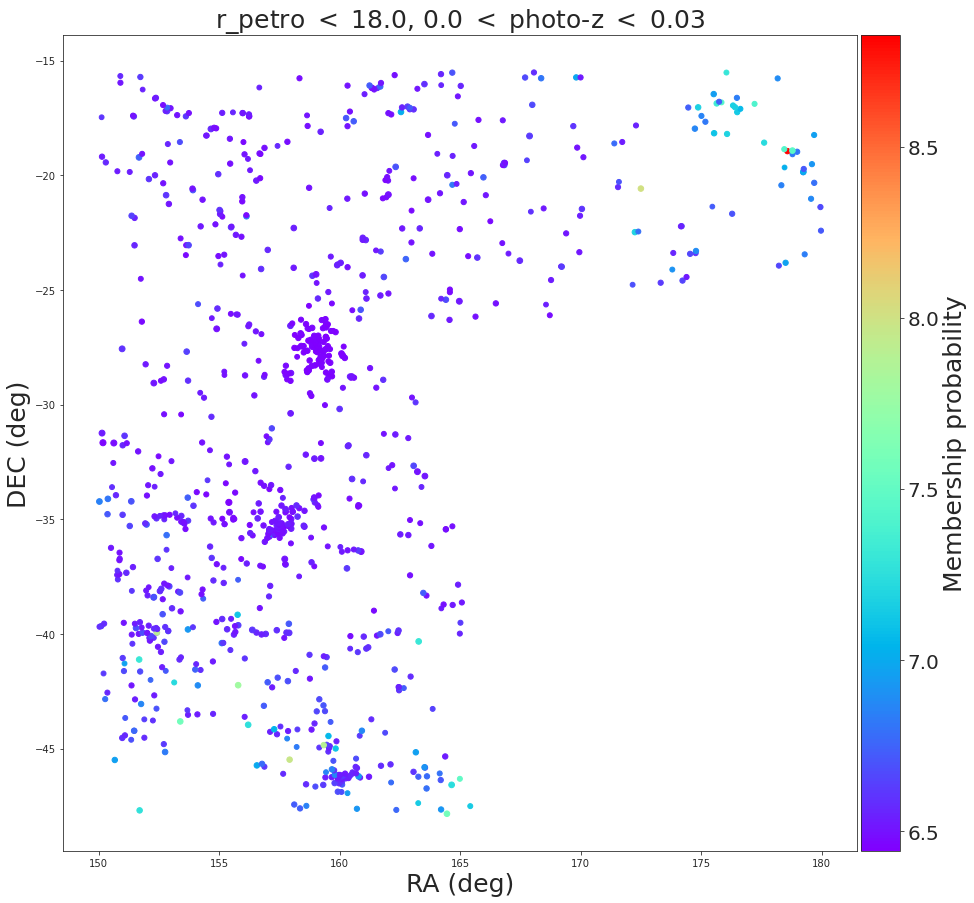

In [47]:
fontsize = 25
labelsize = 20

cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

sc1 = ax.scatter(x=ra, y=dec, c=P_mem, cmap=cm2, s=(1/mags)*400)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title(r"r_petro $<$ {:.1f}, 0.0 $<$ photo-z $<$ 0.03".format(mlim), fontsize=fontsize)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Membership probability", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

Some conclusions: <br>

i) Tem galáxia super longe de Hydra que tem probabilidade mais alta de ser membro de Hydra do que as galáxias perto de Hydra (??????) <br>
ii) Parece que na verdade as probabilidades tão invertidas: quanto mais longe de Hydra maior a probabilidade de ser membro <br>
iii) As probabilidades no geral tão baixas demais, tudo entre 6.5% e 8.5%
